In [1]:
from comet_ml import Experiment

import sys
sys.path.append('..')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns
from matplotlib.colors import LogNorm

from tqdm import tqdm

from modules.mrartemev_ganlib import gans
from modules.mrartemev_ganlib import nn as gans_nn

import torch
from torch import nn
from torch.nn import functional as F
import os


In [2]:
GPU_NUM = 0

In [3]:
cosmic = pd.read_csv('../data/processed/cosmic.csv.gz')
cosmic.head()

,Channel,ADC_ADC_Sig,ADC_ADC_bg,Board,Nhit,Asic_TDC0,Asic_ADC0,Asic_TOT0,Asic_TDC1,Asic_ADC1,...,Asic_TOT4,Asic_TDC5,Asic_ADC5,Asic_TOT5,Asic_TDC6,Asic_ADC6,Asic_TOT6,Asic_TDC7,Asic_ADC7,Asic_TOT7
0,41.0,-0.001751,-1.0,3.0,1.0,-1.0,-1.0,-1.0,0.143853,-0.002085,...,-1.000000,-1.0,-1.0,-1.0,-1.00000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000
1,14.0,0.000875,-1.0,15.0,1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,...,-1.000000,-1.0,-1.0,-1.0,0.10177,0.001617,0.0,-1.000000,-1.000000,-1.000000
2,15.0,-0.003015,-1.0,34.0,1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,...,-1.000000,-1.0,-1.0,-1.0,-1.00000,-1.000000,-1.0,-0.024574,-0.004929,0.047619
3,12.0,0.003501,-1.0,35.0,1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,...,0.047619,-1.0,-1.0,-1.0,-1.00000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000
4,12.0,0.014588,-1.0,56.0,1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,...,0.047619,-1.0,-1.0,-1.0,-1.00000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000


In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = str(GPU_NUM)

c_cols = ['Channel', 'Board', 'ADC_ADC_Sig']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Embeddings

For conditional data

In [5]:
c_disc_cols = ['Channel', 'Board']

Channels: [0, 47]

Boards: [0, 255]



In [6]:
def encode_context(embeddings, context):
    """
    context: Batch_size x [Channel, Board, ADC_ADC_Sig]
    """
    emb_ind = context[:, 0] + context[:, 1] * 48
    context_emb = embeddings(emb_ind.long()).float()
    return torch.cat([context_emb, context[:, 2].unsqueeze(1).float()], dim=1)


### Data

In [7]:
meta_x_cols = ['Nhit', 'ADC_ADC_bg']
group_x_cols = {i: [f'Asic_ADC{i}', f'Asic_TDC{i}', f'Asic_TOT{i}'] for i in range(8)}
x_cols = ['Nhit', 'ADC_ADC_bg']
for i in range(len(group_x_cols)):
    x_cols.extend(group_x_cols[i])

In [8]:
for i in range(len(group_x_cols)):
    cosmic[f'ADC_{i}_ishit'] = (cosmic[f'Asic_ADC{i}'] != -1).astype(np.float32)
    

In [9]:
x_cols = [f'ADC_{i}_ishit' for i in range(len(group_x_cols))]

In [13]:
cosmic.head()

,Channel,ADC_ADC_Sig,ADC_ADC_bg,Board,Nhit,Asic_TDC0,Asic_ADC0,Asic_TOT0,Asic_TDC1,Asic_ADC1,...,Asic_ADC7,Asic_TOT7,ADC_0_ishit,ADC_1_ishit,ADC_2_ishit,ADC_3_ishit,ADC_4_ishit,ADC_5_ishit,ADC_6_ishit,ADC_7_ishit
0,41.0,-0.001751,-1.0,3.0,1.0,-1.0,-1.0,-1.0,0.143853,-0.002085,...,-1.000000,-1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14.0,0.000875,-1.0,15.0,1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,...,-1.000000,-1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,15.0,-0.003015,-1.0,34.0,1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,...,-0.004929,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,12.0,0.003501,-1.0,35.0,1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,...,-1.000000,-1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,12.0,0.014588,-1.0,56.0,1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,...,-1.000000,-1.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [14]:
cosmic[x_cols].head()

,ADC_0_ishit,ADC_1_ishit,ADC_2_ishit,ADC_3_ishit,ADC_4_ishit,ADC_5_ishit,ADC_6_ishit,ADC_7_ishit
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [15]:
sorted(cosmic['Nhit'].unique())

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

Data structure:

**context**: [Channel, Board, ADC_ADC_Sig]

**data**: ['Nhit']

In [22]:
class CustomGenerator(nn.Module):
    def __init__(self, in_features, out_features, hidden_features=32, depth=4, context=False):
        super().__init__()
        self.initial_net = gans_nn.MLP(in_features, hidden_features, hidden_features, depth, context)
        self.hits_net = gans_nn.MLP(hidden_features, 8, hidden_features, depth, context) # Nhits
        
    def forward(self, x, context=None):
        initial = self.initial_net(x, context)
        hits = torch.sigmoid(self.hits_net(initial, context))
#         hard_hits = (hits > 0.5).float() # deterministic
        hard_hits = torch.bernoulli(hits).float() # stochastic
        hard_hits_grad = hits + (hard_hits - hits).detach()
        
        groups = ((1 - hard_hits_grad) * torch.zeros_like(hard_hits_grad) + \
                  hard_hits_grad * torch.ones_like(hard_hits_grad))
        return groups
        
    

In [23]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)
    if isinstance(m, nn.BatchNorm1d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)


In [24]:
dim = len(x_cols)
context_dim = 16


prior = torch.distributions.MultivariateNormal(torch.zeros(64).to(device),
                                               torch.eye(64).to(device))

model = gans.WGAN_GP(dim, prior, base_network=gans_nn.MLP,
                   hidden_features=64, depth=2, context=context_dim
                  )
model.generator = CustomGenerator(prior.event_shape[0], dim, hidden_features=128, depth=2, context=context_dim)
model.c_embs = nn.Embedding(256*48, 15)
model.c_embs.weight.requires_grad = True
model.apply(init_weights)
model.to(device)

gen_optimizer = torch.optim.Adam([{'params': model.generator.parameters(), 'lr': 1e-4, 'weight_decay': 0.0005},
                                  {'params': model.c_embs.parameters(), 'lr': 1e-5}])
disc_optimizer = torch.optim.Adam(model.discriminator.parameters(), lr=1e-6)

gen_scheduler = torch.optim.lr_scheduler.ExponentialLR(gen_optimizer, 0.99)
disc_scheduler = torch.optim.lr_scheduler.ExponentialLR(disc_optimizer, 0.99)

In [25]:
import pickle 

# context: Channel, Board, ADC_ADC_Sig
# data: 'Nhit'

In [26]:
from torch.utils.data import TensorDataset, DataLoader

def get_infinite_loader(loader):
    iter_loader = iter(loader)
    while True:
        try:
            yield next(iter_loader)
        except StopIteration:
            iter_loader = iter(loader)
            yield next(iter_loader)
            
# balance dataset
sample_num = 100000
balanced_cosmic = pd.concat([cosmic[cosmic['Nhit'] != 1].sample(sample_num), 
                             cosmic[cosmic['Nhit'] == 1].sample(sample_num)], axis=0)


            
train_dataloader = TensorDataset(torch.tensor(balanced_cosmic[x_cols].values),
                                 torch.tensor(balanced_cosmic[c_cols].values))
train_dataloader = DataLoader(train_dataloader, batch_size=1024, shuffle=True, drop_last=True)
train_dataloader = get_infinite_loader(train_dataloader)

In [27]:
batch = next(train_dataloader)
x, context = [i.to(device).float() for i in batch]
context = encode_context(model.c_embs, context)
gen_loss = model.calculate_loss_gen(x, context=context)
disc_loss = model.calculate_loss_disc(x, context=context)
gen_loss.mean().item(), disc_loss.mean().item()


(-0.5186907052993774, 0.3088822662830353)

In [28]:
experiment = Experiment(api_key="HIZapbzNjFips0c32Co7gXkQZ",
                        project_name="richgans", workspace="maximartemev")


COMET INFO: old comet version (3.1.4) detected. current: 3.1.6 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET WARNING: Failing to collect the installed os packages
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/maximartemev/richgans/d40b3ac103c0488db22d070c274c4c0e



In [29]:
VAL_INTERVALS = 1500
GEN_UPDATES = 1
DISC_UPDATES = 1

In [30]:
def plot_compare(data):
    plt.figure(figsize=(20, 20))
    x_val = data[x_cols].values
    c_val = data[c_cols].values
    x_gen = model.generate(data.shape[0],
                           encode_context(model.c_embs,
                                          torch.tensor(c_val, device=device)
                                         )
                          ).detach().cpu().numpy()
    
    plot_ind = 0
    for ind, col in enumerate(x_cols):
        if 'ADC' in col or col == 'Nhit':
            plot_ind += 1
            plt.subplot(5, 2, plot_ind)
            _, bins, _ = plt.hist(x_val[:, ind], bins=50, alpha=0.6, label='Real', density=True)
            plt.hist(x_gen[:, ind], bins=bins, alpha=0.6, label='Generated', density=True)
            plt.grid()
            plt.legend()
            plt.title(col)

In [31]:
# mc_noct = pd.read_csv('../data/processed/mcmc_noxtalk.csv.gz', nrows=100000)
# mc_ct = pd.read_csv('../data/processed/mcmc_xtalk.csv.gz', nrows=100000)

mc_noct = balanced_cosmic

mc_ct = balanced_cosmic


In [ ]:
for iteration in tqdm(range(1000000), position=0, leave=True):
    
    if iteration % VAL_INTERVALS == 0:
        model.eval()
        experiment.log_metrics({'gen/lr': gen_optimizer.param_groups[0]['lr'],
                                'disc/lr': disc_optimizer.param_groups[0]['lr']},
                               step=iteration)

        gen_scheduler.step()
        disc_scheduler.step()
        
        plot_compare(mc_noct)
        experiment.log_figure('no_ct', step=iteration)
        plot_compare(mc_ct)
        experiment.log_figure('yes_ct', step=iteration)
        plt.clf()
        x, context = [i.to(device).float() for i in next(train_dataloader)]
        context = encode_context(model.c_embs, context)
        prior_sample = model.prior.sample((x.shape[0],))
        initial = model.generator.initial_net(prior_sample, context=context)
        hits = torch.sigmoid(model.generator.hits_net(initial, context=context))
        print(hits[:5])
    
    model.train()
    # gen update
    for _ in range(GEN_UPDATES):
        x, context = [i.to(device).float() for i in next(train_dataloader)]
        context = encode_context(model.c_embs, context)
        gen_optimizer.zero_grad()
        gen_loss = model.calculate_loss_gen(x, context=context).mean() + \
            ((model.generate(x.shape[0], context=context) - x)**2).mean()
        
        gen_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        gen_optimizer.step()
    experiment.log_metric('train/gen/loss', gen_loss.item(), step=iteration)

    # disc update
    for _ in range(DISC_UPDATES):
        x, context = [i.to(device).float() for i in next(train_dataloader)]
        context = encode_context(model.c_embs, context)
        disc_optimizer.zero_grad()
        disc_loss = model.calculate_loss_disc(x, context=context).mean()
        disc_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
        disc_optimizer.step()
    experiment.log_metric('train/disc/loss', disc_loss.item(), step=iteration)
    

  0%|          | 0/1000000 [00:00<?, ?it/s]/home/user/miniconda/envs/py36/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 1/1000000 [00:05<1401:25:39,  5.05s/it]

tensor([[0.0460, 0.9093, 0.6473, 0.3865, 0.9853, 0.0467, 0.5391, 0.2554],
        [0.3714, 0.4484, 0.9860, 0.2420, 0.9705, 0.0095, 0.1432, 0.1609],
        [0.0346, 0.8458, 0.4067, 0.0293, 0.9005, 0.0207, 0.2992, 0.2619],
        [0.0029, 0.9743, 0.9529, 0.4793, 0.9879, 0.0256, 0.5327, 0.6724],
        [0.0252, 0.5288, 0.4544, 0.2625, 0.9169, 0.1324, 0.2330, 0.3457]],
       device='cuda:0', grad_fn=<SliceBackward>)


  0%|          | 1501/1000000 [01:40<132:45:13,  2.09it/s]

tensor([[6.9237e-01, 9.5291e-01, 9.4547e-04, 9.8363e-01, 7.8379e-03, 9.9804e-01,
         9.9868e-01, 6.3639e-01],
        [9.5620e-01, 9.9999e-01, 6.4033e-05, 9.9997e-01, 2.4733e-02, 9.9939e-01,
         9.9976e-01, 1.1476e-02],
        [3.3326e-01, 2.0857e-02, 1.4759e-04, 9.9425e-01, 6.7231e-01, 9.9858e-01,
         9.9948e-01, 9.4506e-02],
        [3.1471e-02, 9.8144e-01, 2.6586e-03, 9.8438e-01, 8.0040e-01, 9.9346e-01,
         9.9302e-01, 6.4853e-01],
        [2.7891e-01, 3.2219e-01, 4.5052e-04, 9.9666e-01, 4.4411e-01, 9.9863e-01,
         9.9953e-01, 1.3524e-01]], device='cuda:0', grad_fn=<SliceBackward>)


  0%|          | 3004/1000000 [03:14<136:51:25,  2.02it/s]

tensor([[2.2768e-01, 9.9938e-01, 1.3981e-03, 9.9905e-01, 7.1984e-01, 9.9662e-01,
         9.9749e-01, 1.7624e-01],
        [4.1919e-02, 4.7511e-01, 1.1789e-03, 9.5522e-01, 7.8875e-01, 9.9747e-01,
         9.9906e-01, 1.8205e-01],
        [5.2661e-01, 1.2160e-01, 3.6202e-03, 7.6822e-01, 8.3822e-01, 9.9098e-01,
         9.9692e-01, 4.8030e-02],
        [2.1084e-02, 2.3388e-01, 4.3101e-04, 4.2274e-01, 3.6233e-02, 9.9951e-01,
         9.9967e-01, 9.0151e-01],
        [1.3880e-02, 3.5552e-02, 5.7565e-04, 6.7147e-01, 7.6935e-01, 9.9875e-01,
         9.9962e-01, 2.1693e-01]], device='cuda:0', grad_fn=<SliceBackward>)


  0%|          | 4503/1000000 [04:48<144:17:18,  1.92it/s]

tensor([[2.1877e-03, 1.1546e-02, 1.2052e-03, 2.1197e-01, 3.7042e-01, 9.9772e-01,
         9.9934e-01, 8.1911e-01],
        [1.1827e-01, 8.9068e-01, 1.7621e-03, 9.9022e-01, 8.3108e-01, 9.9449e-01,
         9.9775e-01, 7.3631e-01],
        [2.7640e-01, 9.9318e-01, 3.9361e-03, 9.7307e-01, 9.1010e-01, 9.8974e-01,
         9.9341e-01, 1.1069e-01],
        [9.6589e-01, 9.4281e-01, 2.2926e-03, 8.3812e-01, 2.2868e-02, 9.9654e-01,
         9.9772e-01, 4.4956e-02],
        [8.7327e-01, 5.8798e-01, 2.0268e-04, 9.9965e-01, 9.6221e-02, 9.9942e-01,
         9.9982e-01, 8.7864e-04]], device='cuda:0', grad_fn=<SliceBackward>)


  1%|          | 6003/1000000 [06:27<142:59:08,  1.93it/s]

tensor([[9.8946e-01, 9.4210e-02, 1.5940e-04, 9.9965e-01, 1.0260e-01, 9.9932e-01,
         9.9989e-01, 8.5976e-02],
        [1.7462e-02, 6.0910e-01, 4.5718e-03, 6.7971e-01, 8.9178e-01, 9.8546e-01,
         9.9566e-01, 5.6940e-01],
        [4.3099e-01, 1.4523e-02, 1.0145e-03, 9.1363e-01, 1.5886e-01, 9.9637e-01,
         9.9946e-01, 1.3651e-01],
        [2.1275e-02, 9.8150e-01, 2.1974e-03, 9.3605e-01, 9.6036e-01, 9.9179e-01,
         9.9695e-01, 6.8605e-01],
        [9.5910e-01, 6.1057e-01, 4.7010e-04, 9.9034e-01, 1.0571e-02, 9.9882e-01,
         9.9968e-01, 1.9710e-03]], device='cuda:0', grad_fn=<SliceBackward>)


  1%|          | 7502/1000000 [08:05<212:34:37,  1.30it/s]

tensor([[1.6310e-01, 8.5077e-01, 1.6807e-03, 9.9724e-01, 2.9267e-01, 9.9327e-01,
         9.9853e-01, 2.8945e-01],
        [3.1819e-01, 9.9406e-01, 1.3721e-04, 9.9988e-01, 1.2072e-01, 9.9961e-01,
         9.9986e-01, 1.5425e-02],
        [4.4209e-01, 9.1684e-01, 6.0505e-04, 9.9145e-01, 3.3899e-01, 9.9566e-01,
         9.9953e-01, 1.1447e-02],
        [1.9880e-02, 1.9332e-01, 1.9336e-03, 8.2332e-01, 6.5415e-01, 9.3854e-01,
         9.9875e-01, 2.5710e-01],
        [3.9252e-03, 1.6295e-01, 7.3630e-03, 4.5181e-02, 7.8035e-01, 6.4075e-01,
         9.9496e-01, 8.0648e-01]], device='cuda:0', grad_fn=<SliceBackward>)


  1%|          | 9003/1000000 [09:43<159:24:25,  1.73it/s]

tensor([[4.5370e-01, 3.6322e-01, 8.9618e-03, 9.0337e-01, 2.2383e-01, 9.5043e-01,
         9.9351e-01, 5.0391e-01],
        [1.1503e-03, 2.1968e-03, 9.7716e-04, 1.7937e-02, 9.8070e-01, 1.6163e-01,
         9.9971e-01, 4.1273e-02],
        [2.4400e-02, 9.7560e-01, 7.0168e-03, 8.8842e-01, 8.9599e-01, 8.7083e-01,
         9.9293e-01, 6.7609e-01],
        [2.2915e-03, 9.7563e-01, 2.2584e-03, 9.5288e-01, 9.4777e-01, 8.8295e-01,
         9.9779e-01, 6.5518e-01],
        [6.3441e-01, 1.8827e-01, 1.3616e-04, 9.9929e-01, 8.9411e-02, 9.9897e-01,
         9.9992e-01, 3.1246e-02]], device='cuda:0', grad_fn=<SliceBackward>)


  1%|          | 10504/1000000 [11:22<142:09:53,  1.93it/s]

tensor([[6.0221e-02, 7.8139e-01, 4.4183e-03, 8.2329e-01, 2.5311e-02, 9.7244e-01,
         9.9612e-01, 9.2509e-01],
        [1.6100e-01, 9.9225e-01, 2.1408e-04, 9.9869e-01, 7.5658e-01, 9.9721e-01,
         9.9976e-01, 6.0223e-03],
        [1.3084e-02, 8.6785e-01, 3.9804e-03, 9.4842e-01, 7.7588e-01, 9.1743e-01,
         9.9634e-01, 9.1289e-01],
        [1.0666e-02, 4.1362e-01, 9.7821e-03, 8.0780e-01, 9.2633e-01, 1.3626e-01,
         9.9403e-01, 4.9620e-01],
        [1.2889e-03, 9.8522e-01, 1.0291e-03, 8.2221e-01, 8.7012e-01, 9.5731e-01,
         9.9895e-01, 8.5331e-01]], device='cuda:0', grad_fn=<SliceBackward>)


  1%|          | 12002/1000000 [13:02<205:25:21,  1.34it/s]

tensor([[0.4531, 0.3262, 0.0094, 0.3171, 0.4686, 0.7590, 0.9936, 0.0337],
        [0.0015, 0.9851, 0.0015, 0.5200, 0.9951, 0.4011, 0.9987, 0.0997],
        [0.0478, 0.9615, 0.0016, 0.9760, 0.9020, 0.9626, 0.9984, 0.1288],
        [0.9320, 0.9862, 0.0014, 0.9156, 0.0561, 0.9980, 0.9984, 0.0128],
        [0.1386, 0.9419, 0.0021, 0.9786, 0.1950, 0.9567, 0.9980, 0.0968]],
       device='cuda:0', grad_fn=<SliceBackward>)


  1%|▏         | 13502/1000000 [14:40<198:02:49,  1.38it/s]

tensor([[1.9450e-02, 9.9266e-01, 1.4218e-03, 9.7070e-01, 7.4267e-01, 9.8734e-01,
         9.9814e-01, 8.8059e-01],
        [3.7148e-03, 8.9351e-01, 2.4135e-03, 5.3564e-01, 9.9047e-01, 3.0409e-01,
         9.9810e-01, 1.8879e-01],
        [9.3838e-03, 4.3053e-01, 2.3383e-03, 6.3637e-01, 7.3109e-01, 7.0260e-01,
         9.9834e-01, 2.9630e-01],
        [6.9808e-02, 9.9991e-01, 8.2807e-05, 9.9983e-01, 9.1702e-01, 9.9750e-01,
         9.9985e-01, 1.7534e-02],
        [7.9911e-02, 9.7229e-01, 5.1890e-04, 9.8622e-01, 9.2183e-01, 9.8694e-01,
         9.9942e-01, 1.0850e-02]], device='cuda:0', grad_fn=<SliceBackward>)


  2%|▏         | 15000/1000000 [16:15<24:07:40, 11.34it/s] /home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
  2%|▏         | 15002/1000000 [16:20<192:26:12,  1.42it/s]

tensor([[1.3470e-01, 8.5998e-01, 4.1844e-03, 8.0558e-01, 6.7654e-01, 8.8769e-01,
         9.9596e-01, 2.3353e-01],
        [3.4778e-03, 6.8355e-01, 8.4653e-04, 9.6473e-01, 4.8713e-01, 9.7983e-01,
         9.9918e-01, 8.1518e-01],
        [3.8881e-02, 9.9300e-01, 4.0093e-04, 9.8785e-01, 6.5271e-01, 9.9110e-01,
         9.9947e-01, 3.0557e-02],
        [1.4324e-03, 9.2841e-01, 5.2160e-04, 9.4435e-01, 9.2444e-01, 9.8441e-01,
         9.9942e-01, 8.6381e-01],
        [2.6586e-01, 7.5704e-01, 1.1719e-03, 9.8589e-01, 9.7907e-01, 8.2119e-01,
         9.9896e-01, 4.7090e-03]], device='cuda:0', grad_fn=<SliceBackward>)


  2%|▏         | 16502/1000000 [18:01<150:06:07,  1.82it/s]

tensor([[1.2174e-03, 2.1071e-03, 1.5582e-03, 4.5937e-03, 9.3018e-01, 4.8031e-02,
         9.9942e-01, 4.8308e-01],
        [6.3234e-01, 9.1977e-01, 2.4456e-03, 7.6634e-01, 6.0891e-01, 8.3997e-01,
         9.9759e-01, 3.2865e-03],
        [9.8005e-02, 9.0945e-01, 1.8016e-03, 9.3389e-01, 1.2812e-01, 9.9194e-01,
         9.9783e-01, 7.9199e-01],
        [1.8776e-03, 7.0479e-01, 2.8425e-04, 8.8644e-01, 9.8573e-01, 9.5746e-01,
         9.9973e-01, 4.2333e-02],
        [6.3146e-02, 1.9218e-01, 6.5653e-04, 1.8899e-01, 8.3351e-01, 9.3026e-01,
         9.9952e-01, 4.2795e-03]], device='cuda:0', grad_fn=<SliceBackward>)


  2%|▏         | 18002/1000000 [19:38<190:37:02,  1.43it/s]

tensor([[6.7998e-02, 9.9992e-01, 9.5959e-05, 9.9843e-01, 9.9542e-01, 8.2330e-01,
         9.9983e-01, 1.8688e-03],
        [4.2623e-02, 2.1406e-01, 5.9715e-03, 2.2404e-01, 4.8914e-01, 7.2953e-01,
         9.9547e-01, 8.2111e-01],
        [5.7141e-03, 9.9022e-01, 3.7525e-04, 9.7186e-01, 9.9040e-01, 6.9499e-01,
         9.9955e-01, 1.2184e-02],
        [6.0000e-01, 9.9721e-01, 1.2616e-03, 9.8230e-01, 8.8849e-01, 8.0587e-01,
         9.9827e-01, 2.0158e-03],
        [4.7929e-01, 9.4439e-01, 2.9253e-03, 4.5119e-01, 4.1915e-01, 9.7398e-01,
         9.9659e-01, 7.1362e-02]], device='cuda:0', grad_fn=<SliceBackward>)


  2%|▏         | 19503/1000000 [21:19<154:54:22,  1.76it/s]

tensor([[2.9910e-03, 4.5184e-02, 1.4599e-03, 1.6086e-03, 7.6751e-01, 3.2549e-01,
         9.9921e-01, 1.9698e-01],
        [1.7420e-01, 7.2664e-01, 5.3015e-03, 4.6457e-01, 2.9403e-01, 9.5578e-01,
         9.9449e-01, 6.5382e-01],
        [8.5792e-01, 9.9846e-01, 1.0848e-03, 8.6428e-01, 2.6827e-01, 9.5288e-01,
         9.9839e-01, 1.3258e-03],
        [4.3304e-02, 5.1100e-03, 2.4831e-03, 1.6771e-02, 4.2038e-01, 5.3540e-02,
         9.9896e-01, 2.9285e-02],
        [1.0083e-03, 9.8919e-01, 4.9592e-04, 8.8788e-01, 9.8896e-01, 4.8613e-01,
         9.9942e-01, 2.4991e-01]], device='cuda:0', grad_fn=<SliceBackward>)


  2%|▏         | 21003/1000000 [23:07<190:38:58,  1.43it/s]

tensor([[0.7103, 0.5116, 0.0033, 0.9718, 0.9462, 0.5971, 0.9968, 0.0055],
        [0.0729, 0.1268, 0.0057, 0.0900, 0.6832, 0.6527, 0.9957, 0.5310],
        [0.1515, 0.8111, 0.0012, 0.9044, 0.2153, 0.9837, 0.9986, 0.0508],
        [0.0289, 0.1281, 0.0021, 0.1732, 0.1255, 0.7438, 0.9984, 0.4452],
        [0.0662, 0.4841, 0.0082, 0.0383, 0.5149, 0.5561, 0.9932, 0.7362]],
       device='cuda:0', grad_fn=<SliceBackward>)


  2%|▏         | 22501/1000000 [24:54<230:20:43,  1.18it/s]

tensor([[2.0855e-02, 3.8975e-02, 4.3314e-04, 6.6223e-03, 2.7521e-01, 8.8259e-01,
         9.9972e-01, 1.3111e-02],
        [3.3151e-03, 8.9386e-01, 1.1827e-03, 2.8028e-01, 9.7633e-01, 5.3620e-01,
         9.9877e-01, 4.3699e-01],
        [3.0844e-02, 9.9114e-01, 2.6725e-03, 9.5014e-01, 8.8985e-01, 2.9218e-01,
         9.9659e-01, 4.5297e-01],
        [5.0480e-02, 9.8667e-01, 1.9086e-03, 9.0628e-01, 9.8623e-01, 1.5398e-01,
         9.9774e-01, 3.6081e-02],
        [2.0559e-03, 9.9662e-01, 3.2337e-04, 9.9086e-01, 9.9847e-01, 4.2959e-01,
         9.9952e-01, 2.3729e-01]], device='cuda:0', grad_fn=<SliceBackward>)


  2%|▏         | 24002/1000000 [26:37<221:02:37,  1.23it/s]

tensor([[4.3975e-02, 9.2010e-01, 1.6362e-03, 5.9139e-01, 1.2510e-01, 9.8839e-01,
         9.9773e-01, 8.7238e-01],
        [6.7171e-03, 9.7737e-01, 3.5275e-04, 4.5626e-01, 2.3527e-02, 9.9552e-01,
         9.9946e-01, 9.8845e-01],
        [6.5571e-02, 9.9926e-01, 5.1173e-04, 9.8676e-01, 9.9066e-01, 2.7125e-01,
         9.9913e-01, 9.4181e-03],
        [8.9328e-03, 6.8013e-01, 2.9718e-04, 9.1465e-01, 9.7857e-01, 7.3880e-01,
         9.9967e-01, 1.5230e-02],
        [5.3594e-02, 9.9915e-01, 4.6124e-04, 7.8881e-01, 7.5868e-01, 7.6150e-01,
         9.9921e-01, 6.5972e-02]], device='cuda:0', grad_fn=<SliceBackward>)


  3%|▎         | 25502/1000000 [28:20<237:02:20,  1.14it/s]

tensor([[1.9382e-01, 3.7225e-01, 9.3567e-04, 9.1158e-01, 7.3545e-01, 9.8822e-01,
         9.9884e-01, 3.8575e-02],
        [4.7023e-02, 8.3597e-01, 1.5810e-03, 6.3653e-01, 9.7397e-01, 1.7167e-01,
         9.9834e-01, 1.2367e-02],
        [9.2587e-01, 5.6367e-01, 5.7399e-04, 8.7873e-01, 9.2036e-02, 9.5132e-01,
         9.9935e-01, 4.7291e-04],
        [2.7432e-03, 3.4361e-01, 4.5702e-04, 5.5476e-02, 2.9148e-02, 9.7854e-01,
         9.9954e-01, 9.3001e-01],
        [1.5459e-02, 3.3572e-01, 1.7241e-03, 7.5587e-01, 3.5079e-01, 9.5999e-01,
         9.9810e-01, 9.4051e-01]], device='cuda:0', grad_fn=<SliceBackward>)


  3%|▎         | 27001/1000000 [30:02<199:24:40,  1.36it/s]

tensor([[2.8795e-02, 9.3054e-01, 3.1151e-04, 9.1210e-01, 9.9923e-01, 2.9498e-02,
         9.9962e-01, 6.3699e-03],
        [8.1849e-02, 9.9997e-01, 5.4674e-05, 9.9650e-01, 9.9700e-01, 5.6145e-01,
         9.9984e-01, 2.5573e-03],
        [3.7155e-01, 9.9215e-01, 5.7212e-04, 9.8862e-01, 3.3692e-01, 9.9380e-01,
         9.9877e-01, 7.6738e-02],
        [7.4774e-01, 9.9586e-01, 1.5552e-03, 8.8184e-01, 8.7913e-01, 6.1794e-01,
         9.9731e-01, 1.1872e-02],
        [3.3870e-03, 3.7122e-01, 1.5444e-03, 2.5595e-01, 9.6001e-01, 3.3795e-01,
         9.9850e-01, 3.7469e-01]], device='cuda:0', grad_fn=<SliceBackward>)


  3%|▎         | 28502/1000000 [31:45<238:37:11,  1.13it/s]

tensor([[5.9537e-04, 2.7987e-02, 4.1196e-04, 4.7165e-01, 8.3075e-01, 5.9965e-01,
         9.9965e-01, 5.0247e-01],
        [9.8160e-01, 9.6182e-01, 3.9559e-04, 9.7017e-01, 2.1748e-01, 9.4444e-01,
         9.9931e-01, 2.8578e-04],
        [4.8259e-02, 9.9289e-01, 5.1627e-04, 9.4816e-01, 9.7649e-01, 8.9981e-01,
         9.9894e-01, 3.2927e-02],
        [2.5725e-03, 9.6511e-01, 3.4543e-04, 2.0304e-02, 5.5041e-01, 9.8053e-01,
         9.9944e-01, 8.4194e-01],
        [1.9772e-01, 8.6064e-01, 8.0079e-03, 5.8223e-01, 7.9397e-01, 1.2646e-01,
         9.9103e-01, 3.5420e-01]], device='cuda:0', grad_fn=<SliceBackward>)


  3%|▎         | 30002/1000000 [33:27<224:52:33,  1.20it/s]

tensor([[8.2037e-01, 2.6474e-01, 3.0639e-04, 9.8530e-01, 2.3865e-01, 9.9165e-01,
         9.9956e-01, 1.6214e-03],
        [2.8398e-01, 9.9842e-01, 1.2663e-04, 8.5430e-01, 9.6838e-01, 8.0108e-01,
         9.9971e-01, 2.5428e-04],
        [4.7290e-01, 4.9514e-01, 2.7495e-04, 5.6834e-01, 1.0829e-02, 9.9828e-01,
         9.9959e-01, 7.3146e-02],
        [5.8411e-04, 8.8180e-01, 5.4743e-04, 1.6648e-02, 9.1341e-01, 2.1143e-01,
         9.9937e-01, 8.2629e-01],
        [1.7441e-01, 9.2788e-01, 5.0219e-03, 7.6538e-01, 8.4972e-01, 2.7912e-01,
         9.9335e-01, 2.2793e-01]], device='cuda:0', grad_fn=<SliceBackward>)


  3%|▎         | 31502/1000000 [35:09<190:22:01,  1.41it/s]

tensor([[2.4962e-01, 9.8573e-01, 5.1564e-04, 9.9535e-01, 9.8266e-01, 8.1228e-01,
         9.9885e-01, 7.8853e-03],
        [6.9820e-01, 9.9889e-01, 4.9733e-04, 9.8930e-01, 9.0986e-01, 7.4543e-01,
         9.9870e-01, 1.6354e-02],
        [3.5658e-01, 8.6059e-01, 8.5179e-04, 3.2664e-01, 4.9362e-02, 9.9145e-01,
         9.9859e-01, 2.0666e-01],
        [4.3185e-04, 9.9799e-01, 2.9818e-04, 3.3796e-01, 9.7137e-01, 7.5904e-02,
         9.9944e-01, 9.0485e-01],
        [2.6423e-01, 9.1229e-01, 2.4044e-03, 9.6369e-01, 7.5658e-01, 6.8750e-01,
         9.9614e-01, 3.3687e-02]], device='cuda:0', grad_fn=<SliceBackward>)


  3%|▎         | 32783/1000000 [36:29<16:23:10, 16.40it/s] 

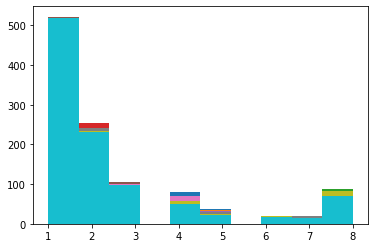

In [43]:
for i in range(10):
    x, context = [i.to(device).float() for i in next(train_dataloader)]
    context = encode_context(model.c_embs, context)
    
    plt.hist(x.view(-1).detach().cpu().numpy())
plt.show()


In [33]:
x, context = [i.to(device).float() for i in next(train_dataloader)]
context = encode_context(model.c_embs, context)

prior_sample = model.prior.sample((x.shape[0],))
initial = model.generator.initial_net(prior_sample, context=context)
hits = model.generator.hits_net(initial, context=context)
hits = torch.sigmoid(hits)
hits


tensor([[0.9961, 0.9964, 0.9971,  ..., 0.9969, 0.9978, 0.9963],
        [0.9955, 0.9957, 0.9972,  ..., 0.9969, 0.9973, 0.9969],
        [0.9960, 0.9952, 0.9976,  ..., 0.9967, 0.9962, 0.9975],
        ...,
        [0.9944, 0.9963, 0.9961,  ..., 0.9970, 0.9969, 0.9949],
        [0.9950, 0.9968, 0.9964,  ..., 0.9968, 0.9974, 0.9947],
        [0.9944, 0.9959, 0.9974,  ..., 0.9958, 0.9952, 0.9962]],
       device='cuda:0', grad_fn=<SigmoidBackward>)

In [34]:
hard_hits = torch.bernoulli(hits).float() 
hard_hits


tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0',
       grad_fn=<BernoulliBackward0>)

In [36]:
hard_hits_grad = hits + (hard_hits - hits).detach()
hard_hits_grad

tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]], device='cuda:0',
       grad_fn=<AddBackward0>)

In [39]:
hard_hits - hits

tensor([[0.0039, 0.0036, 0.0029,  ..., 0.0031, 0.0022, 0.0037],
        [0.0045, 0.0043, 0.0028,  ..., 0.0031, 0.0027, 0.0031],
        [0.0040, 0.0048, 0.0024,  ..., 0.0033, 0.0038, 0.0025],
        ...,
        [0.0056, 0.0037, 0.0039,  ..., 0.0030, 0.0031, 0.0051],
        [0.0050, 0.0032, 0.0036,  ..., 0.0032, 0.0026, 0.0053],
        [0.0056, 0.0041, 0.0026,  ..., 0.0042, 0.0048, 0.0038]],
       device='cuda:0', grad_fn=<SubBackward0>)

In [40]:
hits

tensor([[0.9961, 0.9964, 0.9971,  ..., 0.9969, 0.9978, 0.9963],
        [0.9955, 0.9957, 0.9972,  ..., 0.9969, 0.9973, 0.9969],
        [0.9960, 0.9952, 0.9976,  ..., 0.9967, 0.9962, 0.9975],
        ...,
        [0.9944, 0.9963, 0.9961,  ..., 0.9970, 0.9969, 0.9949],
        [0.9950, 0.9968, 0.9964,  ..., 0.9968, 0.9974, 0.9947],
        [0.9944, 0.9959, 0.9974,  ..., 0.9958, 0.9952, 0.9962]],
       device='cuda:0', grad_fn=<SigmoidBackward>)

In [ ]:
hits = torch.sigmoid(hits)
hits

In [ ]:
# hard_hits = (hits > 0.5).float() # deterministic
hard_hits = torch.bernoulli(hits).float() # stochastic
print(hard_hits)
hard_hits_grad = hits + (hard_hits - hits).detach()
print(hard_hits_grad)

In [ ]:
gen_loss = model.calculate_loss_gen(x, context=context).mean()


In [ ]:
model.generator

In [ ]:
x_val = cosmic.loc[:100000, x_cols].values
c_val = mc_noct.loc[:100000, c_cols].values
x_gen = model.generate(100000,
                       encode_context(model.c_embs,
                                      torch.tensor(c_val, device=device)
                                     )
                      ).detach().cpu().numpy()

In [ ]:
plt.figure(figsize=(20, 50))

plot_ind = 0
for ind, col in enumerate(x_cols):
    if 'ADC' in col and not 'bg' in col:
        plot_ind += 1
        plt.subplot(10, 2, plot_ind)
        _, bins, _ = plt.hist(x_val[x_val[:, ind] != -1, ind], bins=50, alpha=0.6, label='Real, hits')
        plt.hist(x_gen[x_gen[:, ind] != -1, ind], bins=bins, alpha=0.6, label='Generated, hits')
        plt.grid()
        plt.legend()
        plt.title(col)
        plot_ind += 1
        plt.subplot(10, 2, plot_ind)
        _, bins, _ = plt.hist(x_val[x_val[:, ind] == -1, ind], bins=50, alpha=0.6, label='Real, nohits')
        plt.hist(x_gen[x_gen[:, ind] == -1, ind], bins=bins, alpha=0.6, label='Generated, nohits')
        plt.grid()
        plt.legend()
        plt.title(col)
    if 'Nhit' in col:
        plot_ind += 1
        plt.subplot(10, 2, plot_ind)
        _, bins, _ = plt.hist(x_val[x_val[:, ind] != 1, ind], bins=50, alpha=0.6, label='Real, hits')
        plt.hist(x_gen[x_gen[:, ind] != 1, ind], bins=bins, alpha=0.6, label='Generated, hits')
        plt.grid()
        plt.legend()
        plt.title(col)
        plot_ind += 1
        plt.subplot(10, 2, plot_ind)
        _, bins, _ = plt.hist(x_val[x_val[:, ind] == 1, ind], bins=50, alpha=0.6, label='Real, nohits')
        plt.hist(x_gen[x_gen[:, ind] == 1, ind], bins=bins, alpha=0.6, label='Generated, nohits')
        plt.grid()
        plt.legend()
        plt.title(col)
        
    if 'bg' in col:
        plot_ind += 1
        plt.subplot(10, 2, plot_ind)
        _, bins, _ = plt.hist(x_val[x_val[:, ind] != -1, ind], bins=50, alpha=0.6, label='Real, hits')
        plt.hist(x_gen[x_gen[:, ind] != -1, ind], bins=bins, alpha=0.6, label='Generated, hits')
        plt.grid()
        plt.legend()
        plt.title(col)
        plot_ind += 1
        plt.subplot(10, 2, plot_ind)
        _, bins, _ = plt.hist(x_val[x_val[:, ind] == -1, ind], bins=50, alpha=0.6, label='Real, nohits')
        plt.hist(x_gen[x_gen[:, ind] == -1, ind], bins=bins, alpha=0.6, label='Generated, nohits')
        plt.grid()
        plt.legend()
        plt.title(col)

plt.show()

In [ ]:
1

In [ ]:
x_val = mc_noct[x_cols].values
c_val = mc_noct[c_cols].values
x_gen = model.generate(mc_noct.shape[0],
                       encode_context(model.c_embs,
                                      torch.tensor(c_val, device=device)
                                     )
                      ).detach().cpu().numpy()

In [ ]:
plt.figure(figsize=(20, 50))

plot_ind = 0
for ind, col in enumerate(x_cols):
    if 'ADC' in col and not 'bg' in col:
        plot_ind += 1
        plt.subplot(10, 2, plot_ind)
        _, bins, _ = plt.hist(x_val[x_val[:, ind] != -1, ind], bins=50, alpha=0.6, label='Real, hits')
        plt.hist(x_gen[x_gen[:, ind] != -1, ind], bins=bins, alpha=0.6, label='Generated, hits')
        plt.grid()
        plt.legend()
        plt.title(col)
        plot_ind += 1
        plt.subplot(10, 2, plot_ind)
        _, bins, _ = plt.hist(x_val[x_val[:, ind] == -1, ind], bins=50, alpha=0.6, label='Real, nohits')
        plt.hist(x_gen[x_gen[:, ind] == -1, ind], bins=bins, alpha=0.6, label='Generated, nohits')
        plt.grid()
        plt.legend()
        plt.title(col)
    if 'Nhit' in col:
        plot_ind += 1
        plt.subplot(10, 2, plot_ind)
        _, bins, _ = plt.hist(x_val[x_val[:, ind] != 1, ind], bins=50, alpha=0.6, label='Real, hits')
        plt.hist(x_gen[x_gen[:, ind] != 1, ind], bins=bins, alpha=0.6, label='Generated, hits')
        plt.grid()
        plt.legend()
        plt.title(col)
        plot_ind += 1
        plt.subplot(10, 2, plot_ind)
        _, bins, _ = plt.hist(x_val[x_val[:, ind] == 1, ind], bins=50, alpha=0.6, label='Real, nohits')
        plt.hist(x_gen[x_gen[:, ind] == 1, ind], bins=bins, alpha=0.6, label='Generated, nohits')
        plt.grid()
        plt.legend()
        plt.title(col)
        
    if 'bg' in col:
        plot_ind += 1
        plt.subplot(10, 2, plot_ind)
        _, bins, _ = plt.hist(x_val[x_val[:, ind] != 0, ind], bins=50, alpha=0.6, label='Real, hits')
        plt.hist(x_gen[x_gen[:, ind] != 0, ind], bins=bins, alpha=0.6, label='Generated, hits')
        plt.grid()
        plt.legend()
        plt.title(col)
        plot_ind += 1
        plt.subplot(10, 2, plot_ind)
        _, bins, _ = plt.hist(x_val[x_val[:, ind] == 0, ind], bins=50, alpha=0.6, label='Real, nohits')
        plt.hist(x_gen[x_gen[:, ind] == 0, ind], bins=bins, alpha=0.6, label='Generated, nohits')
        plt.grid()
        plt.legend()
        plt.title(col)

plt.show()

In [ ]:
x_val = mc_ct[x_cols].values
c_val = mc_ct[c_cols].values
x_gen = model.generate(mc_ct.shape[0],
                       encode_context(model.c_embs,
                                      torch.tensor(c_val, device=device)
                                     )
                      ).detach().cpu().numpy()

In [ ]:
plt.figure(figsize=(20, 20))

plot_ind = 0
for ind, col in enumerate(x_cols):
    if 'ADC' in col and not 'bg' in col:
        plot_ind += 1
        plt.subplot(5, 2, plot_ind)
        plt.hist(x_val[:, ind], bins=50, alpha=0.6, label='Real', density=True)
        plt.hist(x_gen[:, ind], bins=50, alpha=0.6, label='Generated', density=True)
        plt.grid()
        plt.legend()
        plt.title(col)
plt.show()

In [ ]:
plt.figure(figsize=(20, 20))

plot_ind = 0
for ind, col in enumerate(x_cols):
    if 'ADC' in col or col == 'Nhit':
        plot_ind += 1
        plt.subplot(5, 2, plot_ind)
        plt.hist(x_val[:, ind], bins=50, alpha=0.6, label='Real', density=True)
        plt.hist(x_gen[:, ind], bins=50, alpha=0.6, label='Generated', density=True)
        plt.grid()
        plt.legend()
        plt.title(col)
plt.show()

In [ ]:
torch.save(model.state_dict(), os.path.join('../saved_models/', 'first_wgan' + '.state_dict'))


In [ ]:
1

In [ ]:
mc_noct = pd.read_csv('../data/raw/mcmc_noxtalk.csv.gz', nrows=100000)
plot_compare(mc_noct)

In [ ]:
mc_ct = pd.read_csv('../data/raw/mcmc_xtalk.csv.gz', nrows=100000)
plot_compare(mc_ct)